# Objectness Classification Models Analysis

In [1]:
import os
import sys
import git
import torch
import lightning as L
import matplotlib.pyplot as plt

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(f"{git_root}/objectness_classification")

## Loading data

In [2]:
from datamodule import ObjnessClsDataModule

L.seed_everything(42, workers=True)

dataset = ObjnessClsDataModule(
    dataset_dir=os.path.join(
        os.path.expanduser("~"), "Documents/datasets",
    ),
    dataset_mode="egohos",
    batch_size=1,
    transform_mode="display",
    with_info=True,
)
dataset.setup(stage="test")
dataloader = iter(dataset.test_dataloader()[0])

iter_counter = 0

Global seed set to 42


iter counter: 1
frames shape: torch.Size([1, 3, 224, 224])
label shape: torch.Size([1, 2, 224, 224])
converted frames shape: torch.Size([224, 224, 3])
file name: ('ego4d_32287654-7f5b-4d24-bdb0-5f0ceb6dfd24_13350',)


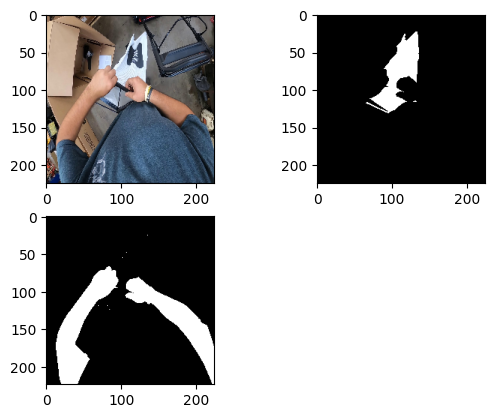

In [3]:
frames, labels, info = next(dataloader)
iter_counter += 1
# convert [batch, channel, height, width]
# to [batch, height, width, channel] for showing
img = frames.permute(0,2,3,1)[0]
mask = labels[0]

print(
    f"iter counter: {iter_counter}",
    f"frames shape: {frames.shape}",
    f"label shape: {labels.shape}",
    f"converted frames shape: {img.shape}",
    f"file name: {info}",
    sep="\n",
)

fig = plt.figure()

fig.add_subplot(2, 2, 1)
plt.imshow(img)

for cls in range(len(mask)):
    fig.add_subplot(2, 2, 2+cls)
    plt.imshow(mask[cls])
    plt.gray()

plt.show()

plt.clf()
plt.close()

## Model prediction

### Single data prediction

In [7]:
from system import ObjnessClsModule

classifier = ObjnessClsModule(
    model_name="setr",
    with_attention=True,
)

model input shape: torch.Size([1, 3, 224, 224])
model output shape: (1, 224, 224)
binary map threshold: 0.5


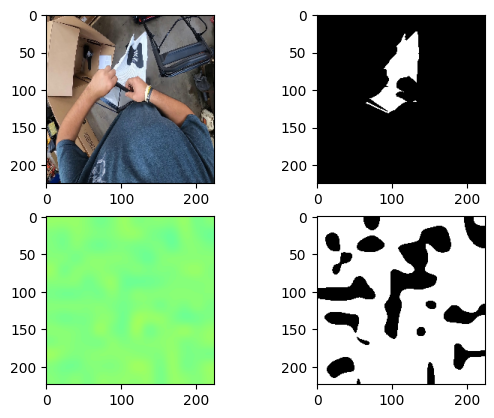

In [9]:
import numpy as np
import cv2

threshold = 0.5

input = frames.float()
with torch.no_grad():
    logits, attention = classifier(input)
preds = logits.sigmoid()
output = preds.float().detach().numpy()[0]

print(
    f"model input shape: {input.shape}",
    f"model output shape: {output.shape}",
    f"binary map threshold: {threshold}",
    sep="\n",
)

fig = plt.figure()

fig.add_subplot(2, 2, 1)
plt.imshow(img)

fig.add_subplot(2, 2, 2)
plt.imshow(mask[0])
plt.gray()

for cls in range(len(output)):
    fig.add_subplot(2, 2, 3+cls)
    heatmap = cv2.applyColorMap(
        (output[cls] * 255).astype(np.uint8),
        cv2.COLORMAP_JET,
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    plt.imshow(heatmap)

    fig.add_subplot(2, 2, 3+cls+1)
    binary_mask = output[cls] > threshold
    plt.imshow(binary_mask)
    plt.gray()

    break

plt.show()

plt.clf()
plt.close()

### Attention map visualization

In [10]:
import matplotlib.colors as clr
import matplotlib.cm as cm

def visualize_class_attention(
    img, attention, layer=-1, cls_token=0, cls_token_num=1, average_head=True,
    head=0, show_raw_map=False,
):
    # get class attention of layer (usually last layer)
    cls_att = attention[layer][:,:,cls_token,cls_token_num:]
    if average_head:
        cls_att = cls_att.mean(dim=1).squeeze(0)
    else:
        cls_att = cls_att.squeeze(0)[head]
    cls_att = cls_att.view(14,14).detach().numpy().copy()

    print(cls_att.shape)

    # visualize class attention maps
    if show_raw_map:
        fig = plt.figure()
        plt.imshow(cls_att)
        plt.show()

    # # visualize class attention maps with input frames
    fig = plt.figure()
    plt.axis("off")

    cls_att_map = cv2.resize(cls_att, (224,224))
    # normalize to range 0~1
    map_min, map_max = np.min(cls_att_map), np.max(cls_att_map)
    norm_map = (cls_att_map - map_min)/(map_max - map_min)

    plt.imshow(img[0].permute(1,2,0))
    plt.imshow(norm_map, alpha=0.4, cmap="jet")

    # create new axis for colorbar, and show
    plt.subplots_adjust(right=0.8)
    plt.colorbar(
        cm.ScalarMappable(norm=clr.Normalize(vmin=0, vmax=1), cmap="jet"),
        cax=fig.add_axes([0.85,0.15,0.05,0.7]),
    )

    plt.show()

(14, 14)


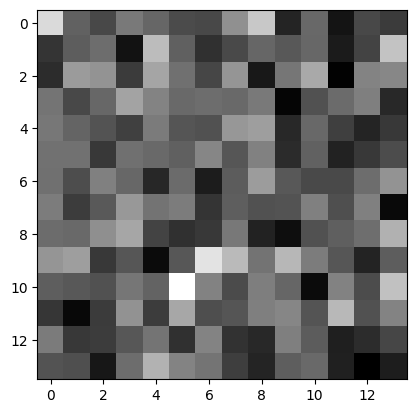

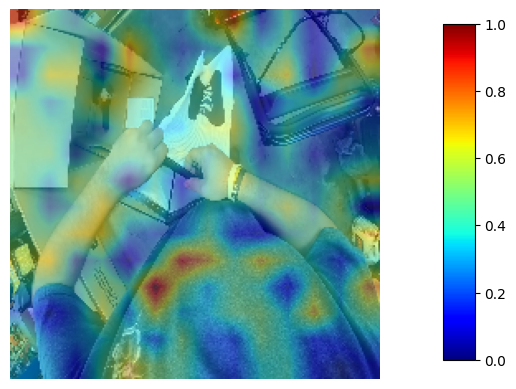

In [11]:
visualize_class_attention(input, attention, show_raw_map=True)

## Heatmap of encoder

input shape: torch.Size([1, 3, 224, 224])
non-trained resnet output shape: torch.Size([1, 1000])
resnet output shape: torch.Size([1, 1000])
Argmax of output: 811 811


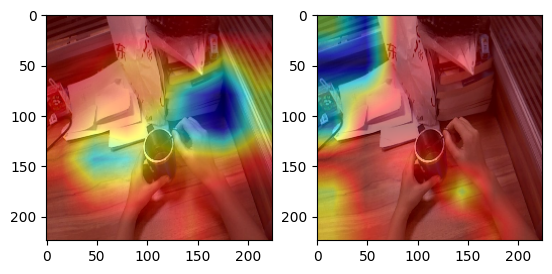

In [211]:
import numpy as np
import cv2
import torchvision.models as models
from torchcam.methods import GradCAM

# find argmax of non-trained model prediction
nt_resnet = models.resnet101(weights='DEFAULT')
nt_resnet.eval()

nt_cam_extractor = GradCAM(nt_resnet)

nt_out = nt_resnet(input)
class_idx = nt_out.squeeze(0).argmax().item()

# apply trained weight to model
param = torch.load(model_path, map_location=torch.device('cpu'))#["state_dict"]
new_param = {}
for k in param.keys():
    # if "model.unet.encoder" in k:
    if "encoder" in k:
        new_param[k[8:]] = param[k]

resnet = models.resnet101(weights='DEFAULT')
resnet.load_state_dict(new_param, strict=False)
resnet.eval()

cam_extractor = GradCAM(resnet)

out = resnet(input)
class_idx2 = nt_out.squeeze(0).argmax().item()

print(
    f"input shape: {input.shape}",
    f"non-trained resnet output shape: {nt_out.shape}",
    f"resnet output shape: {out.shape}",
    f"Argmax of output: {class_idx} {class_idx2}",
    sep="\n",
)

# function to create heatmap from given CAMs
def create_heatmap(cams):
    for cam in cams:
        map = cam.squeeze(0).numpy()

        map_min = np.min(map)
        map_max = np.max(map)
        map = (map - map_min)/(map_max - map_min)

        map = cv2.resize(map, (224,224))
        map = (map*255).astype(np.uint8)

        heatmap = cv2.applyColorMap(map, cv2.COLORMAP_JET)
        output = heatmap * 0.5 + img.detach().numpy() * 0.5 * 255

    return output

# show heatmaps of CAM
nt_heatmap = create_heatmap(nt_cam_extractor(class_idx, nt_out))
heatmap = create_heatmap(cam_extractor(class_idx2, out))

fig = plt.figure()

fig.add_subplot(1, 2, 1)
plt.imshow(nt_heatmap.astype(np.uint8))

fig.add_subplot(1, 2, 2)
plt.imshow(heatmap.astype(np.uint8))

plt.show()

plt.clf()
plt.close()
